1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

***** First method: *****


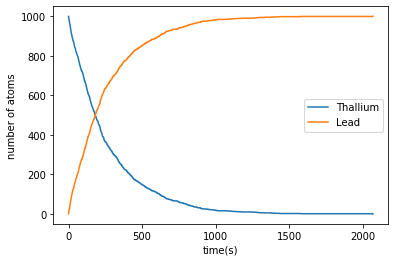

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math

import matplotlib.pyplot as plt
%matplotlib inline
%precision 10

N_Tl=1000
N_Pb=0
Tl = []
Pb = []
T_max=3600

# Esercizio 1
print("***** First method: *****")
tau = 3.052*60 
decay_prob = 1 - 2**(-1/tau) #t=1csec

for i in range(0,T_max):
    n_decay=0
    if(N_Tl!=0):
        for i in range(N_Tl):
            n_rand = np.random.rand()
            if(n_rand<decay_prob):
                n_decay+=1
        N_Tl=N_Tl-n_decay  
        N_Pb=N_Pb+n_decay
        Tl.append(N_Tl)
        Pb.append(N_Pb)
    else: 
        break    
                    
                
plt.plot(Tl, label="Thallium") 
plt.plot(Pb, label="Lead")
plt.xlabel("time(s)")
plt.ylabel("number of atoms")
plt.legend()
plt.show()        




***** Second method: *****


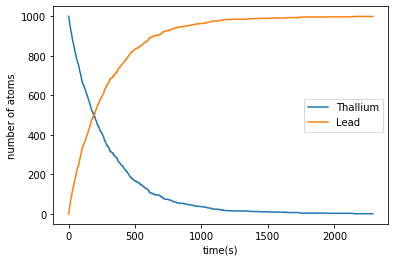

In [2]:
#Esercizio 2: inverse transform method
print("***** Second method: *****")
def expon_icdf(p, mu=1):
    return -np.log(1-p)/mu #inverse cdf of exponential function

rand = np.random.rand(1000)
tau = 3.052*60 # seconds
inv_cdf = expon_icdf(rand, np.log(2)/tau)
Tl = []
Pb = []
for t in range(int(inv_cdf.max())+1):
    Tl.append((inv_cdf > t).sum())
    Pb.append((inv_cdf < t).sum())
    
plt.plot(Tl, label="Thallium") 
plt.plot(Pb, label="Lead")
plt.xlabel("time(s)")
plt.ylabel("number of atoms")
plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Fraction of particle that bounce back:  0.027392


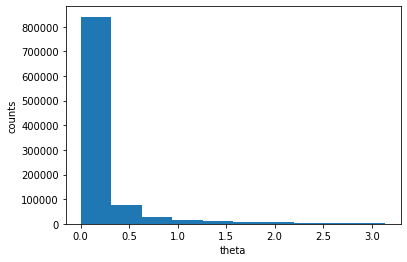

In [3]:
N=10**6
a0=5.3*10**(-11)
e=1.6*10**(-19)
epsilon_0=8.85*10**(-12)

mean=[0.0,0.0]
sigma=[[a0/100,0],[0,a0/100]]
beam=np.random.multivariate_normal(mean, sigma, N)

b=(beam[:,0]**2+beam[:,1]**2)
#print(b)

theta=2*np.arctan(79*e**2/(2*np.pi*epsilon_0*7.7*10**(6)*e*b))

#print(theta)

plt.hist(theta)
plt.xlabel("theta")
plt.ylabel("counts")

bounce_back=[]
for i in theta:
    if(i>(np.pi/2)):
        bounce_back.append(i)

print("Fraction of particle that bounce back: ", len(bounce_back)/N)        
    


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

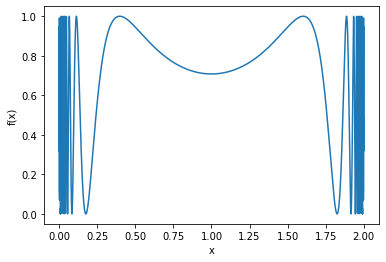

Integral with hit or miss method: 1.45466
Integral mean value method: 1.4510604205776287


In [4]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.00001,1.99999,5000)
plt.plot(x, f(x))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()
#hit and miss method and mean method
N=100000
count=0
somma=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): 
        count+=1
    somma+=f(x)
I_hm=2*count/N #I=A*k/N
I_m=2*somma/N #I=A*sum/N
print("Integral with hit or miss method:",I_hm)
print("Integral mean value method:",I_m)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [5]:
#2D
#Write general N dimentional sphere to compute both 2D and 10D case
def circ(X):
    c=0
    for i in range(0, X.size):
        c+=X[i]**2
    if c<=1: return 1
    else: return 0

N=100000
dim=2
f=0
for i in range(N):
    X_2D=2*(np.random.random(2)-[0.5,0.5]) #between -1, 1
    f+=circ(X_2D)
A=2**dim
I_2D=A*f/N
print("Integrale cerchio 2D: ", I_2D)

N=100000
dim=10
f=0
for i in range(N):
    X_10D=2*(np.random.random(10)-0.5) #between -1, 1
    f+=circ(X_10D)
A=2**dim
I_10D=A*f/N
print("Integrale cerchio 10D: ", I_10D)

Integrale cerchio 2D:  3.1396
Integrale cerchio 10D:  2.67264


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [6]:
print("*Esercizio 5 *")
print("***** Integral with Importance Sampling *****")
def f(x):
    num=x**(-0.5)
    den= math.exp(x)+1
    return num/den

def w(x):
    return 1/(x**0.5)

N=100000
w_integral=2
frac = 0

for i in range(N):
    x = np.random.rand()
    frac += f(x)/w(x)
    
f_integral = frac/N*w_integral

print("Integral=", f_integral)


*Esercizio 5 *
***** Integral with Importance Sampling *****
Integral= 0.7602682473111776
